This is a notebook to generate mel-spectrograms from a TTS model to be used for WaveRNN training.

In [1]:
TTS_PATH = "../../"

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(TTS_PATH)
import torch
import importlib
import numpy as np
import torch.nn as nn
from tqdm import tqdm as tqdm
from torch.utils.data import DataLoader
from TTS.models.tacotron2 import Tacotron2
from TTS.datasets.TTSDataset import MyDataset
from TTS.utils.audio import AudioProcessor
from TTS.utils.visual import plot_spectrogram
from TTS.utils.generic_utils import load_config, setup_model
from TTS.datasets.preprocess import biaobei
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
def set_filename(wav_path, out_path):
    wav_file = os.path.basename(wav_path)
    file_name = wav_file.split('.')[0]
    os.makedirs(os.path.join(out_path, "quant"), exist_ok=True)
    os.makedirs(os.path.join(out_path, "mel"), exist_ok=True)
    os.makedirs(os.path.join(out_path, "wav_gl"), exist_ok=True)
    wavq_path = os.path.join(out_path, "quant", file_name)
    mel_path = os.path.join(out_path, "mel", file_name)
    wav_path = os.path.join(out_path, "wav_gl", file_name)
    return file_name, wavq_path, mel_path, wav_path

In [4]:
OUT_PATH = "/search/hadoop07/wuzijun/voice_data/Biaobei/Mels"
DATA_PATH = "/search/hadoop07/wuzijun/voice_data/Biaobei/"
DATASET = "Biaobei"
METADATA_FILE = "audio_text_filelist.txt"
MODEL_FILE = "../../TTS/output/Biaobei-December-11-2019_08+24AM-536ef91/best_model.pth.tar"
CONFIG_PATH = "../../TTS/config.json"
VOCODER_CONFIG_PATH = "../config.json"

DRY_RUN = False   # if False, does not generate output files, only computes loss and visuals.
BATCH_SIZE = 32

use_cuda = torch.cuda.is_available()
print(" > CUDA enabled: ", use_cuda)

C = load_config(CONFIG_PATH)
C_vocoder = load_config(VOCODER_CONFIG_PATH)
ap = AudioProcessor(**C.audio)

# enable/disable some TTS options manually
C.prenet_dropout = False
C.separate_stopnet = True
C.use_forward_attn = False
C.forward_attn_mask = False

 > CUDA enabled:  True
 > Setting up Audio Processor...
 | > sample_rate:48000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:12.5
 | > frame_length_ms:50
 | > ref_level_db:20
 | > num_freq:2049
 | > power:1.5
 | > preemphasis:0.98
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:125.0
 | > mel_fmax:7600.0
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > sound_norm:False
 | > n_fft:4096
 | > hop_length:600
 | > win_length:2400


In [5]:
preprocessor = importlib.import_module('TTS.datasets.preprocess')
preprocessor = getattr(preprocessor, DATASET.lower())

In [6]:
meta_data = preprocessor(DATA_PATH, METADATA_FILE)

In [7]:
dataset = MyDataset(C.r, C.text_cleaner, ap, meta_data, use_phonemes=C.use_phonemes,  phoneme_cache_path=C.phoneme_cache_path)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=8, collate_fn=dataset.collate_fn, shuffle=False, drop_last=False)

In [8]:
from TTS.utils.text.symbols import symbols, phonemes
from TTS.utils.generic_utils import sequence_mask
from TTS.layers.losses import L1LossMasked, MSELossMasked
from TTS.utils.text.symbols import symbols, phonemes

# load the model
num_chars = len(phonemes) if C.use_phonemes else len(symbols)
model = setup_model(num_chars, 0, C)
checkpoint = torch.load(MODEL_FILE)
model.load_state_dict(checkpoint['model'])
print(checkpoint['step'])
model.eval()
if use_cuda:
    model = model.cuda()

 > Using model: Tacotron2
80650


### Generate model outputs 

In [10]:
import pickle

file_idxs = []
losses_lm = []
losses_mse = []
postnet_losses_lm = []
postnet_losses_mse = []
criterion_lm = L1LossMasked()
criterion_mse = MSELossMasked()
for data in tqdm(loader):
    # setup input data
    text_input = data[0]
    text_lengths = data[1]
    speaker_names = data[2]
    linear_input = data[3] if C.model in ["Tacotron"] else None
    mel_input = data[4]
    mel_lengths = data[5]
    stop_targets = data[6]
    item_idx = data[7]
    
    # dispatch data to GPU
    if use_cuda:
        text_input = text_input.cuda()
        text_lengths = text_lengths.cuda()
        mel_input = mel_input.cuda()
        mel_lengths = mel_lengths.cuda()
#         linear_input = linear_input.cuda()
        stop_targets = stop_targets.cuda()
    
    mask = sequence_mask(text_lengths)
    mel_outputs, postnet_outputs, alignments, stop_tokens = model.forward(text_input, text_lengths, mel_input)
    
    # compute mel specs from linear spec if model is Tacotron
    mel_specs = []
    if C.model == "Tacotron":
        postnet_outputs = postnet_outputs.data.cpu().numpy()
        for b in range(postnet_outputs.shape[0]):
            postnet_output = postnet_outputs[b]
            mel_specs.append(torch.FloatTensor(ap.out_linear_to_mel(postnet_output.T).T).cuda())
        # change incident here
        postnet_outputs = torch.stack(mel_specs)
    
    loss_lm = criterion_lm(mel_outputs, mel_input, mel_lengths)
    loss_postnet_lm = criterion_lm(postnet_outputs, mel_input, mel_lengths)
    losses_lm.append(loss_lm.item())
    postnet_losses_lm.append(loss_postnet_lm.item())
    
    loss_mse = criterion_mse(mel_outputs, mel_input, mel_lengths)
    loss_postnet_mse = criterion_mse(postnet_outputs, mel_input, mel_lengths)
    losses_mse.append(loss_mse.item())
    postnet_losses_mse.append(loss_postnet_mse.item())
    if not DRY_RUN:
        for idx in range(text_input.shape[0]):
            wav_file_path = item_idx[idx]
            wav = ap.load_wav(wav_file_path)
            file_name, wavq_path, mel_path, wav_path = set_filename(wav_file_path, OUT_PATH)
            file_idxs.append(file_name)

            # quantize and save wav
            if type(C_vocoder.mode) is int and C_vocoder.mulaw:
                wavq = ap.mulaw_encode(wav, C_vocoder.mode)
                np.save(wavq_path, wavq, allow_pickle=False)
            elif type(C_vocoder.mode) is int:
                wavq = ap.quantize(wav)
                np.save(wavq_path, wavq, allow_pickle=False)

            # save TTS mel
            mel = postnet_outputs[idx]
            mel = mel.data.cpu().numpy()
            mel_length = mel_lengths[idx]
            mel = mel[:mel_length, :].T
            np.save(mel_path, mel)

            # save GL voice
    #         wav_gen = ap.inv_mel_spectrogram(mel.T) # mel to wav
    #         wav_gen = ap.quantize(wav_gen)
    #         np.save(wav_path, wav_gen)

if not DRY_RUN:
    pickle.dump(file_idxs, open(OUT_PATH+"/dataset_ids.pkl", "wb"))      

100%|██████████| 313/313 [06:21<00:00,  1.22s/it]


In [11]:
print(f"L1maskloss: mel-{np.mean(losses_lm)}; postnet{np.mean(postnet_losses_lm)}")
print(f"MSEloss: mel-{np.mean(losses_mse)}; postnet{np.mean(postnet_losses_mse)}")

L1maskloss: mel-0.1657168586223651; postnet0.14032733435638414
MSEloss: mel-0.04986029319441357; postnet0.03491753430221789


### Check model performance

(601, 80)


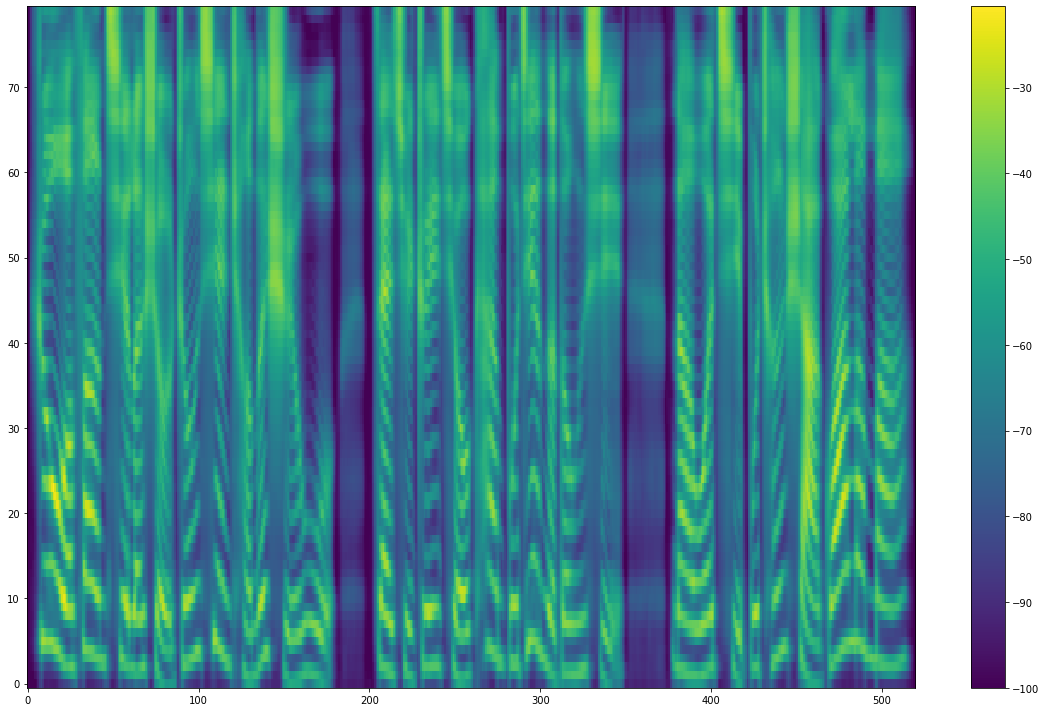

In [18]:
idx = 3
mel_example = postnet_outputs[idx].data.cpu().numpy()
plot_spectrogram(mel_example[:mel_lengths[idx], :], ap);
print(mel_example[:mel_lengths[1], :].shape)

(601, 80)


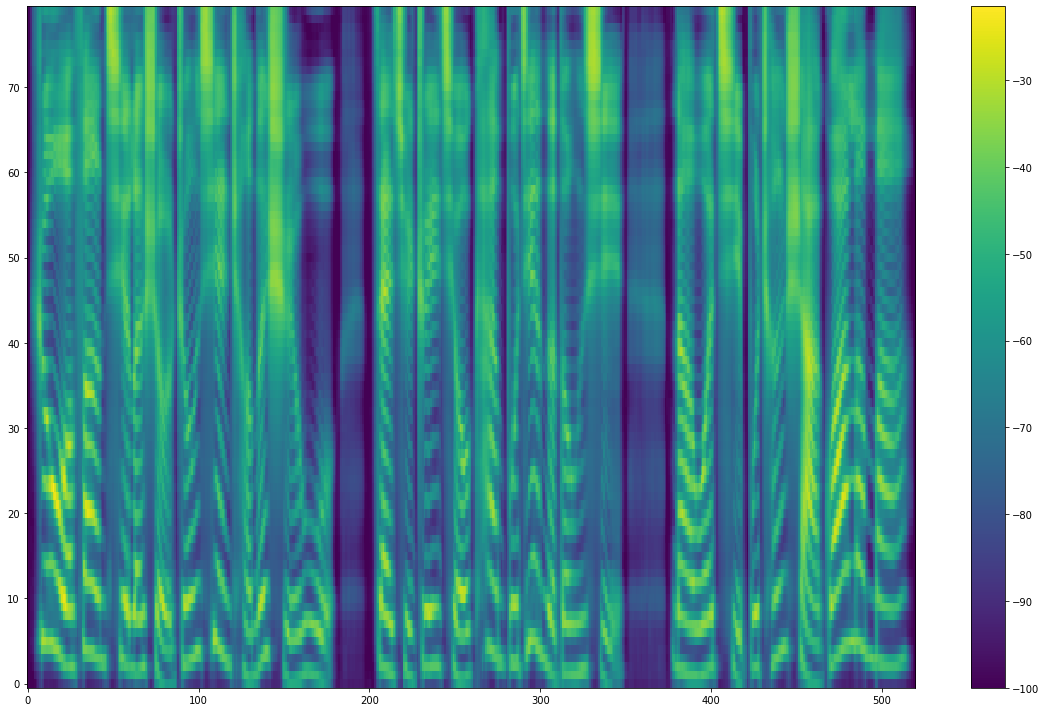

In [19]:
mel_example = mel_outputs[idx].data.cpu().numpy()
plot_spectrogram(mel_example[:mel_lengths[idx], :], ap);
print(mel_example[:mel_lengths[1], :].shape)

(80, 520)


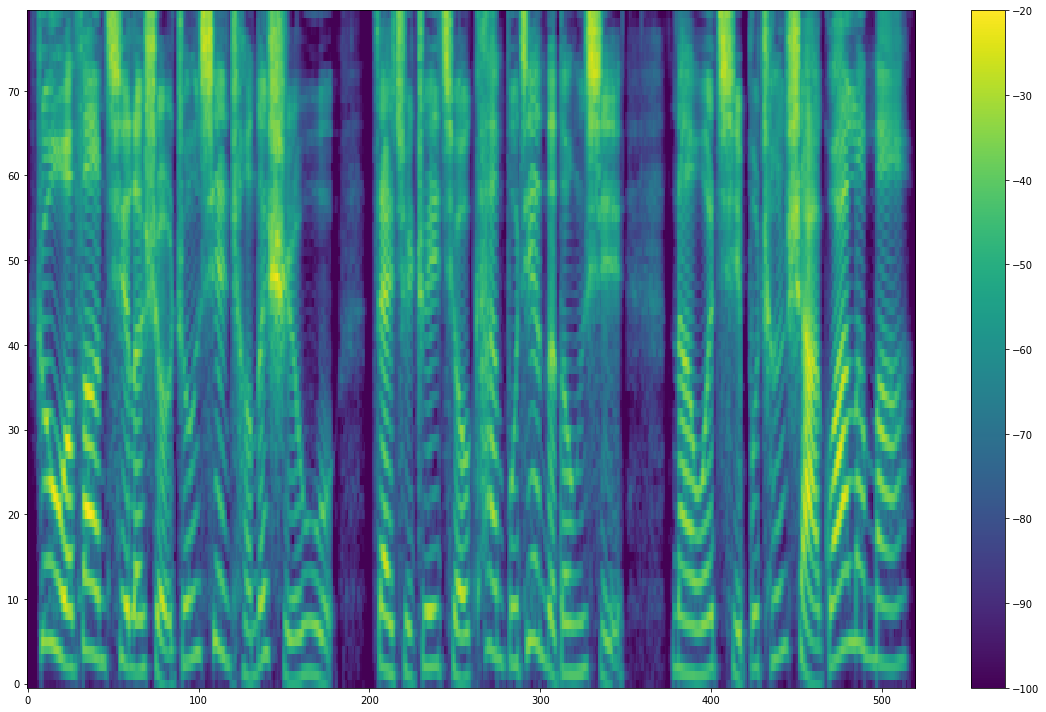

In [20]:
wav = ap.load_wav(item_idx[idx])
melt = ap.melspectrogram(wav)
print(melt.shape)
plot_spectrogram(melt.T, ap);

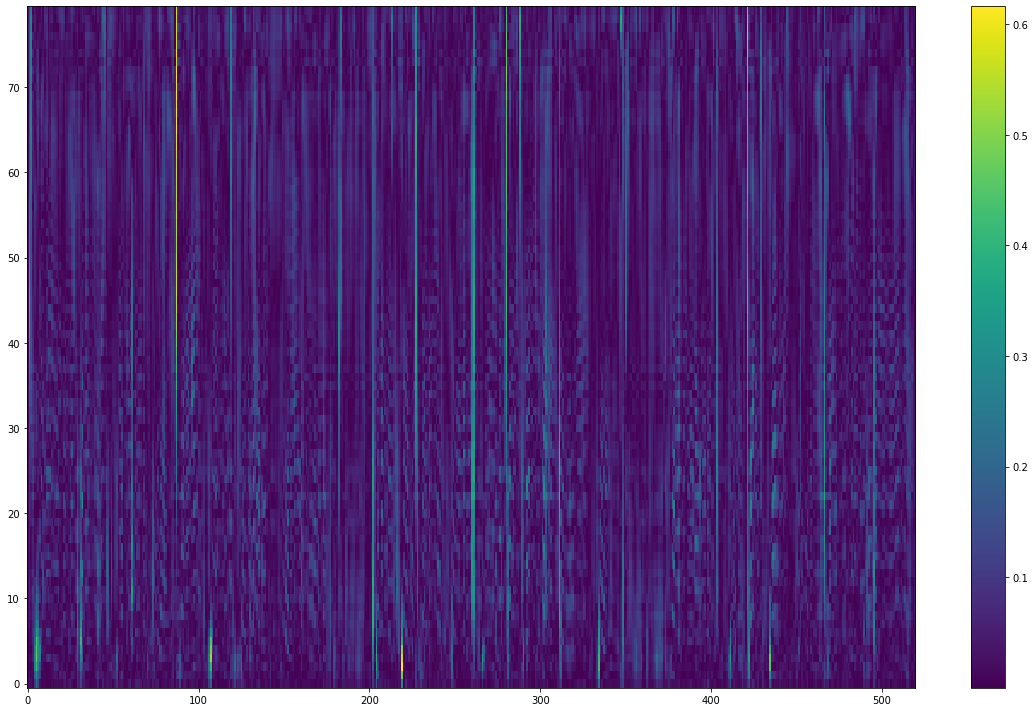

In [21]:
# postnet, decoder diff
from matplotlib import pylab as plt
mel_diff = mel_outputs[idx] - postnet_outputs[idx]
plt.figure(figsize=(16, 10))
plt.imshow(abs(mel_diff.detach().cpu().numpy()[:mel_lengths[idx],:]).T,aspect="auto", origin="lower");
plt.colorbar()
plt.tight_layout()

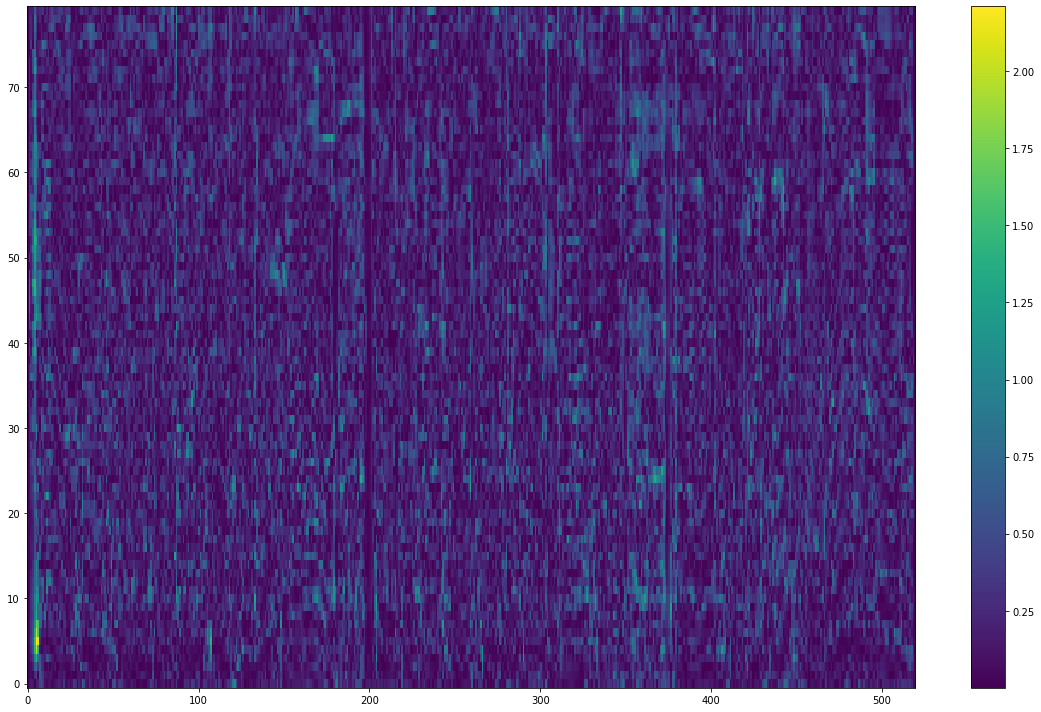

In [22]:
from matplotlib import pylab as plt
# mel = mel_poutputs[idx].detach().cpu().numpy()
mel = postnet_outputs[idx].detach().cpu().numpy()
mel_diff2 = melt.T - mel[:melt.shape[1]]
plt.figure(figsize=(16, 10))
plt.imshow(abs(mel_diff2).T,aspect="auto", origin="lower");
plt.colorbar()
plt.tight_layout()